MI


In [5]:
import pandas as pd
import numpy as np
import os


def normalize(value, min_val, max_val):
    if max_val == min_val:
        return 5.5  # Neutral value when no variation
    scaled = 1 + 9 * ((value - min_val) / (max_val - min_val))
    return round(max(1.0, min(10.0, scaled)), 2)

def calculate_mi(row):
    mi = (
        9.5513
        - 0.9485 * np.log(row['methods_per_class'])
        + 0.0387 * np.log(row['params_per_method'])
        - 0.9103 * np.log(row['cyclomatic_complexity'])
        + 0.3225 * np.log(row['comment_density'])
        - 0.1907 * np.log(row['loc_per_method'])
        + 1.5427 * np.log(row['public_methods'])
        - 0.2952 * np.log(row['nesting_depth'])
        - 1.5038 * np.log(row['halstead_volume'])
    )
    return mi

def interpret_mi(value):
    if value > 7.5:
        return 'Highly maintainable'
    elif value >= 5:
        return 'Moderately maintainable'
    else:
        return 'Difficult to maintain'

df = pd.read_csv('reports/Matrics25.csv')

df = df.iloc[:252]
df = df[(df[['methods_per_class', 'params_per_method', 'cyclomatic_complexity', 'comment_density',
             'loc_per_method', 'public_methods', 'nesting_depth', 'halstead_volume']] != 0).all(axis=1)]

df['MI'] = df.apply(calculate_mi, axis=1).round(2)



df['Interpretation'] = df['MI'].apply(interpret_mi)


average_mi = df['MI'].mean()
average_mi = round(average_mi, 2)
print(f"✅ Average MI across all rows: {average_mi}")

df.to_csv('reports/MI25.csv', index=False)
print("✅ Output with MI and interpretation saved to 'Reports'")


✅ Average MI across all rows: 8.63
✅ Output with MI and interpretation saved to 'Reports'


Results for Gemini-pro:
MI Rating = 8.5016
MI Interpretation = Highly Maintainable
----------------------------------------
Results for Gemini 2.0-flash:
MI Rating = 8.6263
MI Interpretation = Highly Maintainable
----------------------------------------
Results for Llama3.2:
MI Rating = 8.4216
MI Interpretation = Moderately Maintainable
----------------------------------------


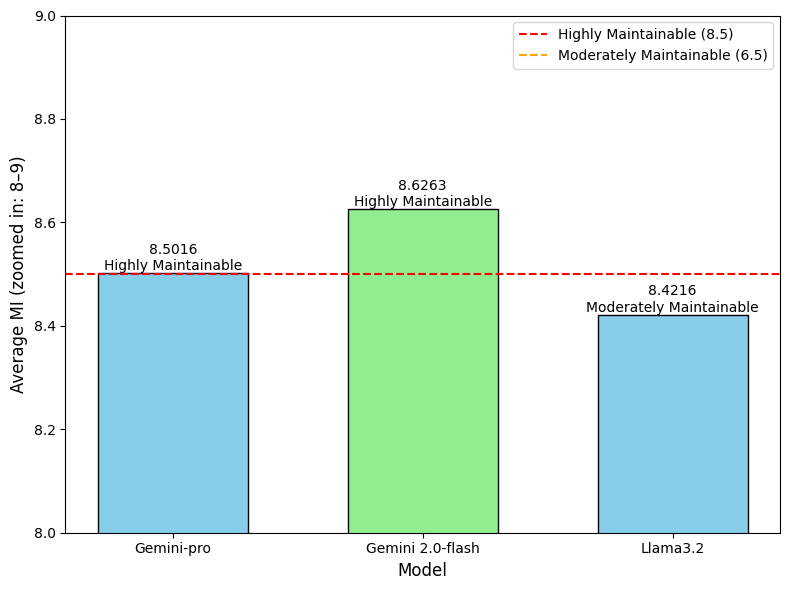

In [6]:
import pandas as pd
import matplotlib.pyplot as plt


file_paths = {
    "Gemini-pro": "reports/MI24.csv",
    "Gemini 2.0-flash": "reports/MI25.csv",
    "Llama3.2":"reports/llama3.2.csv"
}

results = {
    "Model": [],
    "Average MI": [],
    "Interpretation": []
}

for model, file_path in file_paths.items():
    df = pd.read_csv(file_path)
    average_mi = df["MI"].mean()
    average_mi_rounded = round(average_mi, 4)

    if average_mi_rounded > 8.5:
        average_interpretation = "Highly Maintainable"
    elif average_mi_rounded > 6.5:
        average_interpretation = "Moderately Maintainable"
    else:
        average_interpretation = "Difficult to Maintain"


    results["Model"].append(model)
    results["Average MI"].append(average_mi_rounded)
    results["Interpretation"].append(average_interpretation)

    print(f"Results for {model}:")
    print(f"MI Rating = {average_mi_rounded}")
    print(f"MI Interpretation = {average_interpretation}")
    print("-" * 40)

results_df = pd.DataFrame(results)

plt.figure(figsize=(8, 6))
bars = plt.bar(results_df["Model"], results_df["Average MI"],
               color=['skyblue', 'lightgreen'], width=0.6, edgecolor='black')

plt.axhline(y=8.5, color='red', linestyle='--', label="Highly Maintainable (8.5)")
plt.axhline(y=6.5, color='orange', linestyle='--', label="Moderately Maintainable (6.5)")

plt.xlabel("Model", fontsize=12)
plt.ylabel("Average MI (zoomed in: 8–9)", fontsize=12)
# plt.title("Comparison of Average Maintainability Index", fontsize=14)

# Annotate each bar with MI value and interpretation
for bar, mi_value, interpretation in zip(bars, results_df["Average MI"], results_df["Interpretation"]):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height,
             f"{mi_value:.4f}\n{interpretation}",
             ha='center', va='bottom', fontsize=10, color='black')

plt.ylim(8, 9)
plt.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Distribution of MI Scores')

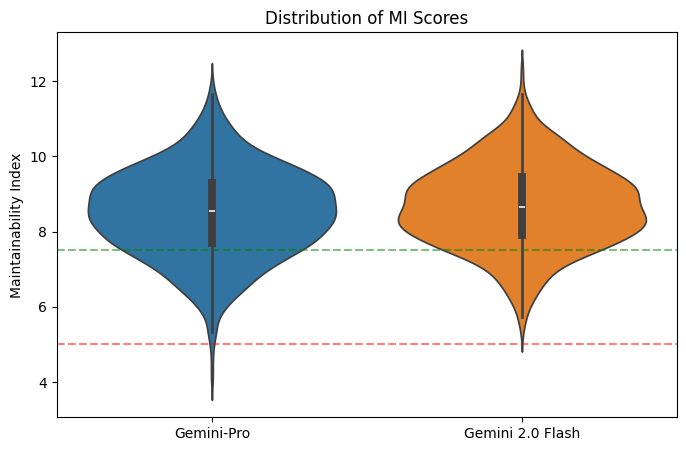

In [14]:
import seaborn as sns
plt.figure(figsize=(8,5))
sns.violinplot(data=[gemini_pro, gemini_flash], 
               palette=["#1f77b4", "#ff7f0e"], 
               inner="box")
plt.axhline(7.5, linestyle='--', color='green', alpha=0.5)
plt.axhline(5.0, linestyle='--', color='red', alpha=0.5)
plt.xticks([0,1], ['Gemini-Pro', 'Gemini 2.0 Flash'])
plt.ylabel("Maintainability Index")
plt.title("Distribution of MI Scores")